# Output visualization and quantitative analysis

In [1]:
%matplotlib inline
from pathlib import Path

import physicool.processing as processing
import pandas as pd

# Basic visualization
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns

# User interaction and online visualization
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import HTML

## Plotting the microenvironment concentrations

PhysiCell stores the **microenvironment data** of the simulations **as a grid**. Therefore, **heatmaps** are a nice way of representing this data.

We can use the `processing` module from `physicool` to extract this data from the `.mat` files. Subsequently, we use `seaborn` to plot the data as a heatmap at **a given time point** of the simulation. We will also need to select **which substance** to plot.

Feel free to change the **time point**, **the substance** (the cancer-biorobots example has "oxygen", "chemoattractant" and "therapeutic" as substances, so either of these names will work) and the **color palette** to be used.

In [2]:
# Where to find the output files
output_path = Path("output/")

# Choose what to plot (be careful to choose valid time points and substances)
time = 54
substance = "oxygen"           

# Select the color scheme ("Reds","Greens", any seaborn palette)
cmap = "Blues"

# z-plane to be plotted, in 2D simulations should be 0
z_level = 0

# Read data
me = processing.Microenvironment(time, output_path)

# Create a figure
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot the heatmap
sns.heatmap(me.data[substance][z_level],
            ax=ax,
            xticklabels=False, yticklabels=False,
            cmap=cmap,
            square=True)
    
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'output/output00000000.xml'

Alterantively, we can create an **animation** of the simulation results to see the evolution of a given substance over time.

In [34]:
# Choose what substances to plot (be careful to choose valid substances)
substance = "chemoattractant"

# Select how many frames the animation should have (from the start to a given simulation time step)
last_time_step = 54

# Set the colormap limits (min and max concentrations)
min_value = 0
max_value = 1                   # Change to 40 when plotting oxygen

# Select the color scheme ("Reds","Greens", any seaborn palette)
cmap = "Greens"

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

def init():
    """Initial function to plot the first time point data and define the constant elements."""
    me = processing.Microenvironment(0, output_path)
    sns.heatmap(me.data[substance][z_level],
        ax=ax,
        vmin=min_value, vmax=max_value,
        xticklabels=False, yticklabels=False,
        cmap=cmap,
        square=True)

def animate(i):
    """Update function to plot new values into the heatmap."""
    me = processing.Microenvironment(i, output_path)
    sns.heatmap(me.data[substance][z_level],
            ax=ax,
            vmin=min_value, vmax=max_value,
            xticklabels=False, yticklabels=False,
            cmap=cmap,
            square=True,
            cbar=False)

# Create the animation using the previous function
anim = animation.FuncAnimation(fig=fig, func=animate, init_func=init, 
                               frames=last_time_step, blit=False, repeat=False)

# Avoid duplicated results
plt.close()
# Visualize the animation
HTML(anim.to_jshtml())

### Plotting the cell data

The `processing` module can also be used to get cell data.

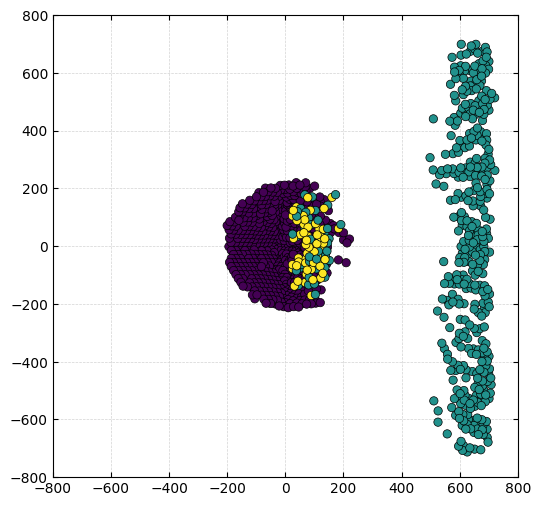

In [58]:
# Choose what time point to plot (be careful to choose valid times)
time = 54

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Get the cell positions and types
data = processing.get_cell_data(variables=["ID", "position_x", "position_y", "cell_type"], 
                                timestep=time)

# Plot the cell centers and color them based on their types
ax.scatter(data["position_x"], data["position_y"], c=data["cell_type"], 
            edgecolors="black", linewidth=0.5)

# Limits
ax.set_ylim(-800, 800)
ax.set_xlim(-800, 800)

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)
ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)

# Ticks
ax.tick_params(axis="y", direction="in", right=True)
ax.tick_params(axis="x", direction="in", top=True)

We can also get data from multiple points and plot the cell trajectories.

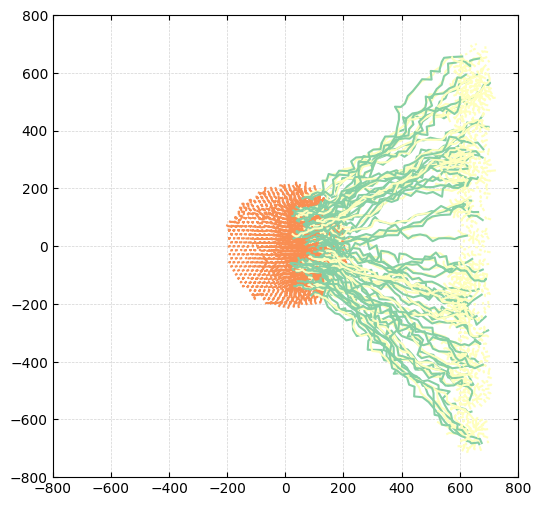

In [118]:
# Choose what time point to plot (be careful to choose valid times)
last_time_step = 54

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

all_time_data = []

for time in range(last_time_step+1):
    # Get the cell positions and types
    data = processing.get_cell_data(variables=["ID", "position_x", "position_y", "cell_type", "current_phase"], 
                                    timestep=time)
    all_time_data.append(data)

final_data = pd.concat(all_time_data)

for cell_id in final_data["ID"].unique():
    cell_data = final_data[final_data["ID"] == cell_id]
    ax.plot(cell_data["position_x"], cell_data["position_y"], 
            c=colors[int(cell_data["cell_type"].values[0])])

# Limits
ax.set_ylim(-800, 800)
ax.set_xlim(-800, 800)

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)
ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)

# Ticks
ax.tick_params(axis="y", direction="in", right=True)
ax.tick_params(axis="x", direction="in", top=True)

### Quantiative analysis

For example, we can get the number of cells over time (differentiating each cell type).

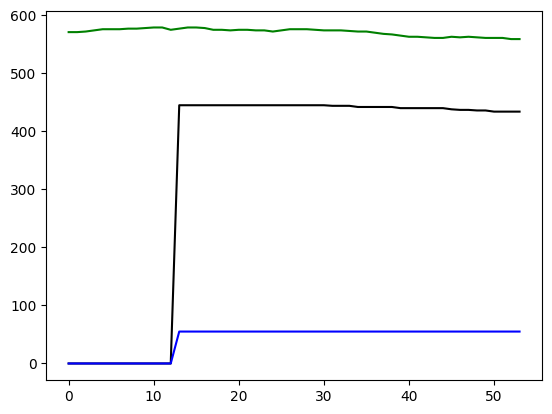

In [119]:
numbers_per_type = {0: [], 1: [], 2: []}
for time in range(last_time_step):
    time_data = final_data[final_data["timestep"] == time]
    numbers_per_type[0].append(len(time_data[time_data["cell_type"] == 0]["ID"]))
    numbers_per_type[1].append(len(time_data[time_data["cell_type"] == 1]["ID"]))
    numbers_per_type[2].append(len(time_data[time_data["cell_type"] == 2]["ID"]))

plt.plot(numbers_per_type[0], "green")
plt.plot(numbers_per_type[1], "black")
plt.plot(numbers_per_type[2], "blue")

We can also select one cell type and plot the number of cells of each status (alive vs dead).

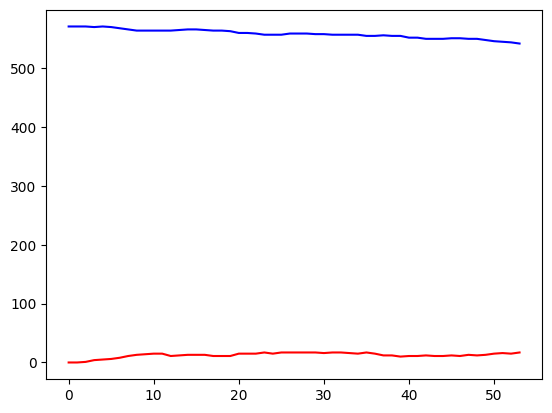

In [125]:
cancer_data = final_data[final_data["cell_type"] == 0]
numbers_per_type = {"alive": [], "dead": []}

for time in range(last_time_step):
    time_data = cancer_data[cancer_data["timestep"] == time]
    numbers_per_type["alive"].append(len(time_data[time_data["current_phase"] == 14]["ID"]))
    numbers_per_type["dead"].append(len(time_data[time_data["current_phase"] == 100]["ID"]))

plt.plot(numbers_per_type["alive"], "blue")
plt.plot(numbers_per_type["dead"], "red")